In [104]:
import mne
import pathlib
import json
import re
import numpy as np
import pandas as pd
from scipy import signal as s
import matplotlib.pyplot as plt

In [58]:
USEFUL_CHANNELS = [
"FP1-F7",
"F7-T7",
"T7-P7",
"P7-O1",
"FP1-F3",
"F3-C3",
"C3-P3",
"P3-O1",
"FP2-F4",
"F4-C4",
"C4-P4",
"P4-O2",
"FP2-F8",
"F8-T8",
"T8-P8",
"P8-O2",
"FZ-CZ",
"CZ-PZ",
"T7-FT9",
"FT9-FT10",
"FT10-T8"
]

# new_names = dict(
#     (ch_name,
#     ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
#     for ch_name in USEFUL_CHANNELS)
# USEFUL_CHANNELS = [new_names[x] for x in USEFUL_CHANNELS]

In [47]:
for ch in raw.ch_names:
    if ch not in USEFUL_CHANNELS:
        print(ch)
        # raw.drop_channels(ch)

In [61]:
def read_raw_edf(edf_path: pathlib.Path, channels=None) -> mne.io.Raw:
    if channels is None:
        channels = []
    raw_edf = mne.io.read_raw_edf(edf_path, stim_channel=None, include=channels)  # type: ignore

    if "T8-P8-1" in raw_edf.ch_names:
        raw_edf.drop_channels("T8-P8-1")
        new_names = {"T8-P8-0": "T8-P8"}
        raw_edf.rename_channels(new_names)

    raw_edf.reorder_channels(channels)
    return raw_edf

In [98]:
path = pathlib.Path("/media/HDD/Unisa/Datasets/CHB_MIT/chb15/chb15_02.edf")

raw = read_raw_edf(path, channels=USEFUL_CHANNELS)

raw = raw.copy().crop(0, 5, include_tmax=False)

# epochs = mne.make_fixed_length_epochs(raw, duration=6.0, preload=True, overlap=1.0, id=1)
# data = epochs.get_data()

# print(data.shape)

# raw.ch_names
# for ch in MISSING:
#     for found_ch in raw.ch_names:
#         if ch in found_ch:
#             print(f"{ch} ~ {found_ch}")
# data = raw.get_data()
    
# channel1 = data[raw.ch_names.index("T8-P8-0"), :]
# channel2 = data[raw.ch_names.index("T8-P8-1"), :]


# new_names = dict(
#     (ch_name,
    # #  ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
#     # for ch_name in raw.ch_names)
# # raw.rename_channels(new_names)

# # new_names = dict(
#     # (ch_name,
    # #  ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
#     # for ch_name in USEFUL_CHANNELS)
# USEFUL_CHANNELS = [new_names[x] for x in USEFUL_CHANNELS]

Extracting EDF parameters from /media/HDD/Unisa/Datasets/CHB_MIT/chb15/chb15_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_22802/729399859.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_edf = mne.io.read_raw_edf(edf_path, stim_channel=None, include=channels)  # type: ignore


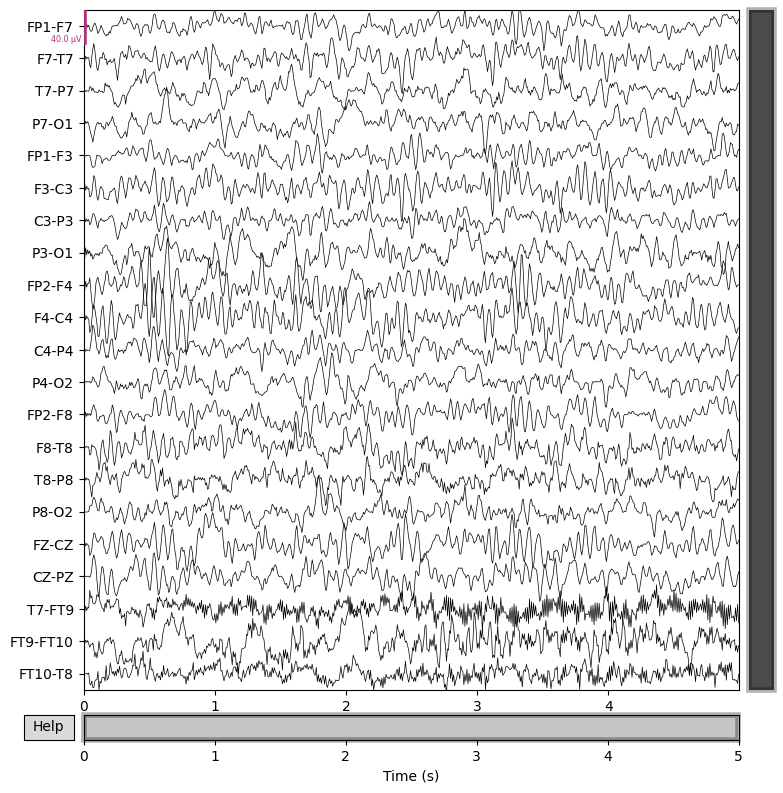

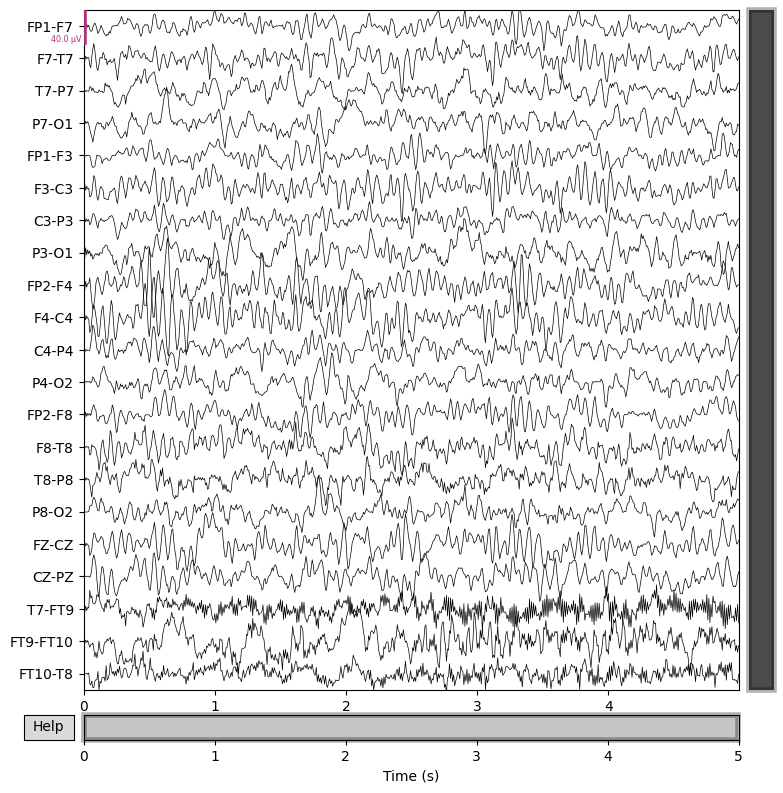

In [91]:
raw.plot(n_channels=22)

In [20]:
def load_paper_labels(filepath: pathlib.Path):
    data_y = np.load(filepath, allow_pickle=True)  # metadatos

    data_y = pd.DataFrame(data_y, columns=['type', 'name', 'filename', 'pre1', 'pre2', 'id_eeg_actual', 'id_eeg_all', 'label'])
    data_y.label = data_y.label.astype('int')

    return data_y

In [29]:
def load_paper_data(filepath: pathlib.Path):
    x_data = np.load(filepath, allow_pickle=True)
    return x_data

In [40]:
paper_dirpath = pathlib.Path('/media/HDD/Unisa/Datasets/EEG data/')
normal_x_filename = 'normal_1_0_data_x.npy'
normal_y_filename = "normal_1_0_data_y.npy"

paper_y_normal = load_paper_labels(paper_dirpath/normal_y_filename)
paper_x_normal = load_paper_data(paper_dirpath/normal_x_filename)


In [41]:
idxs = paper_y_normal.index[paper_y_normal["filename"] == "chb15_02.edf"][:5]

In [42]:
paper_x_normal_slice = paper_x_normal[idxs].reshape(21, -1)

Creating RawArray with float64 data, n_channels=21, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.


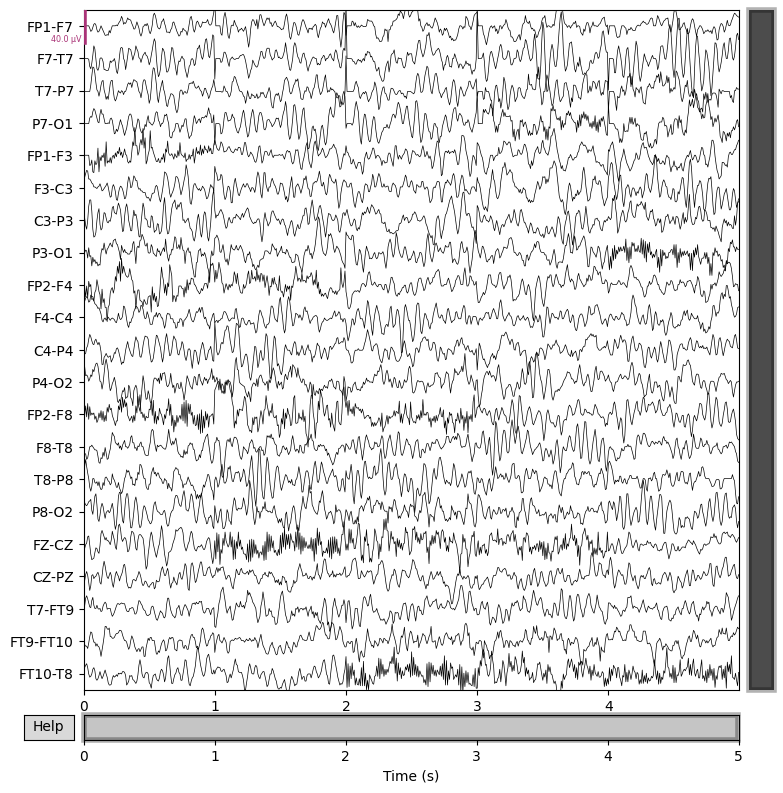

In [78]:
info=mne.create_info(ch_names=raw.ch_names, sfreq=128, ch_types='eeg')
np_diff = mne.io.RawArray(paper_x_normal_slice/1e6, info)
p = np_diff.plot(n_channels=21)

In [99]:
npraw = raw.get_data().astype(np.float32)

In [94]:
npraw[0].shape

(640,)

In [82]:
paper_x_normal_slice[0, ::2].shape

(320,)

In [84]:
npraw[0, :].shape

(1281,)

In [142]:
slice = paper_x_normal_slice[:, :128*5]/1e6

In [143]:
nprawslice = npraw[:, :256*5:2]

In [100]:
diff = paper_x_normal_slice[:, :128*5]/1e6 - npraw[:, :256*5:2]

Creating RawArray with float64 data, n_channels=21, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.


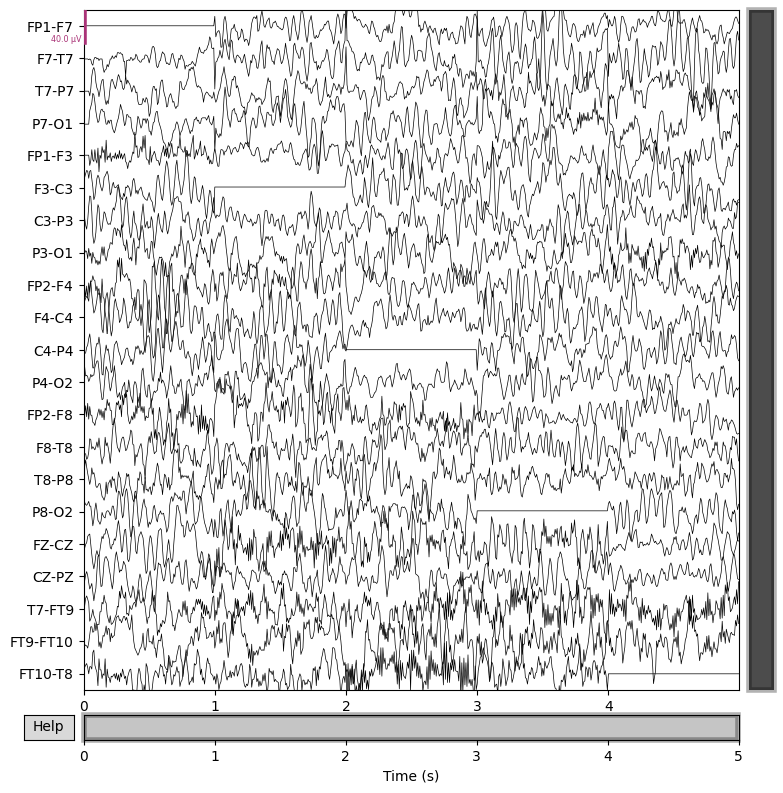

In [101]:
info=mne.create_info(ch_names=raw.ch_names, sfreq=128, ch_types='eeg')
np_diff = mne.io.RawArray(diff, info)
p = np_diff.plot(n_channels=21)

In [71]:
npraw[0]

array([-4.6398047e-05,  4.8840047e-07,  4.8840047e-07, ...,
        8.3028081e-06,  1.1233211e-05,  1.0256410e-05], dtype=float32)

In [114]:
def createSpec(data):
    f, t, Pxx = s.spectrogram(data, nfft=128, fs=128, nperseg=128, return_onesided=True, noverlap=0)

    # result = (10*np.log10(np.transpose(Pxx))-(10*np.log10(np.transpose(Pxx))).min())/(10*np.log10(np.transpose(Pxx))).ptp()
    return f, t, Pxx

In [130]:
def plot_spectrogram(data):
    f, t, Pxx = createSpec(data)

    plt.pcolormesh(t, f, Pxx, shading='gouraud')

    plt.ylabel('Frequency [Hz]')

    plt.xlabel('Time [sec]')

    plt.show()

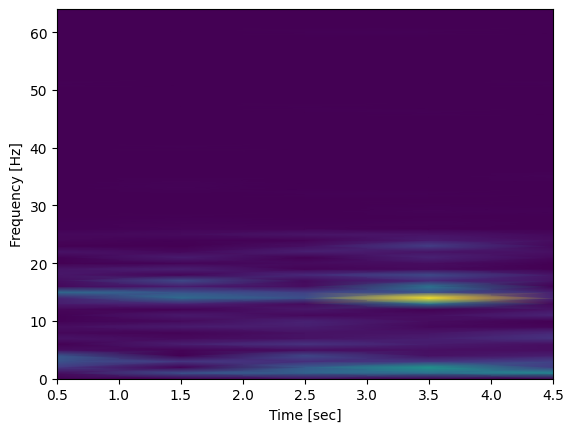

In [145]:
plot_spectrogram(nprawslice[0])

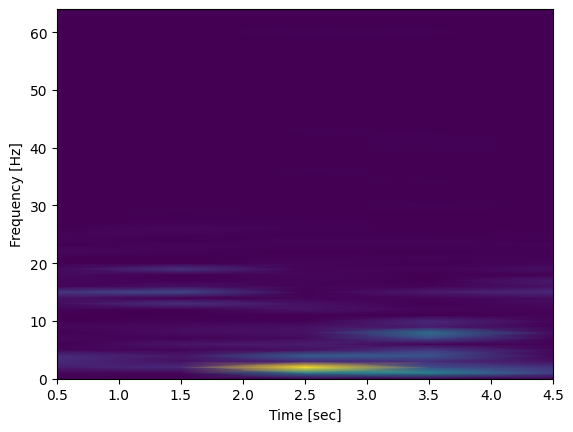

In [146]:
plot_spectrogram(slice[0])

In [148]:
slice[0] - nprawslice[0]

array([ 3.6379788e-12,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00, -2.2737368e-13, -4.5474735e-13,
       -4.5474735e-13, -1.1368684e-13,  2.2737368e-13,  2.2737368e-13,
        1.1368684e-13, -4.5474735e-13, -4.5474735e-13, -4.5474735e-13,
       -2.2737368e-13,  0.0000000e+00, -2.2737368e-13, -4.5474735e-13,
       -9.0949470e-13, -9.0949470e-13, -9.0949470e-13, -9.0949470e-13,
       -9.0949470e-13, -4.5474735e-13, -9.0949470e-13, -2.2737368e-13,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        1.1368684e-13,  0.0000000e+00,  2.2737368e-13,  4.5474735e-13,
        4.5474735e-13,  9.0949470e-13,  9.0949470e-13,  2.2737368e-13,
        4.5474735e-13,  2.2737368e-13,  4.5474735e-13,  9.0949470e-13,
        9.0949470e-13,  9.0949470e-13,  4.5474735e-13,  2.2737368e-13,
        0.0000000e+00, -2.2737368e-13, -2.2737368e-13,  0.0000000e+00,
        4.5474735e-13,  1.1368684e-13, -2.2737368e-13, -9.0949470e-13,
      

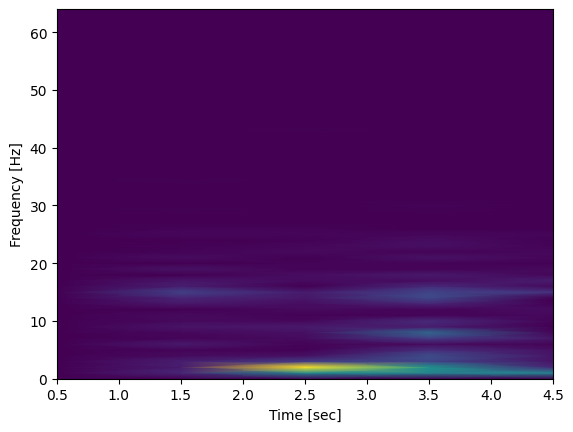

In [147]:
plot_spectrogram(diff[0])

In [125]:
plot_spectrogram(raw.get_data()[0])

ValueError: too many values to unpack (expected 2)

In [12]:
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage, on_missing="ignore")



<RawEDF | chb15_01.edf, 31 x 922112 (3602.0 s), ~36 kB, data not loaded>

In [20]:
print("raw contains", len(raw.ch_names))

print("Missing")
for channel in USEFUL_CHANNELS:
    if channel not in raw.ch_names:
        print(channel)

print("\nExtra")
for channel in raw.ch_names:
    if channel not in USEFUL_CHANNELS:
        print(channel)

raw contains 31
Missing
P7-T7
T7-FT9
FT9-FT10
FT10-T8

Extra
--0
--1
--2
--3
--4
FC1-REF
FC2-REF
FC5-REF
FC6-REF
CP1-REF
CP2-REF
CP5-REF
CP6-REF


In [83]:
montage = mne.channels.make_standard_montage("standard_1005")

# exclude = ["(?i).*-REF", ".*-Ref", "ECG", "VNS"]
# for channel in COMMON_CHANNELS.split(","):
#     for i in range(5):
#         exclude.append(f"{channel}-{i+1}")

def read_data(path):
    raw = mne.io.read_raw_edf(path, stim_channel=None, include=COMMON_CHANNELS, verbose="ERROR")

    if "T8-P8-1" in raw.ch_names:
        raw.drop_channels("T8-P8-1")
        new_names = {"T8-P8-0": "T8-P8"}
        raw.rename_channels(new_names)

    raw.reorder_channels(COMMON_CHANNELS)


    # new_names = dict(
    #     (ch_name,
    #     ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    #     for ch_name in raw.ch_names)
    # raw.rename_channels(new_names)

    # raw = raw.set_montage(montage, on_missing="ignore")

    # new_ch_names = raw.ch_names
    return raw.ch_names

    # if len(new_ch_names) < len(original_ch_names):
    #     raise f"Canali diminuiti in {path}"

    # return raw
    # parsed_ch_names = sorted(set(["-".join(channel.split("-")[:2]) for channel in original_ch_names if not channel.startswith("--")]))
    # return ",".join(parsed_ch_names)

In [73]:
COMMON_CHANNELS = [
    "FP1-F7",
    "F7-T7",
    "T7-P7",
    "P7-O1",
    "FP1-F3",
    "F3-C3",
    "C3-P3",
    "P3-O1",
    "FP2-F4",
    "F4-C4",
    "C4-P4",
    "P4-O2",
    "FP2-F8",
    "F8-T8",
    "P8-O2",
    "FZ-CZ",
    "CZ-PZ",
    "T8-P8"
]
# COMMON_CHANNELS = ["-".join(sorted(channel.split("-")[:2])) for channel in COMMON_CHANNELS]

In [50]:
slices_path = pathlib.Path("output/300/slices.json")
dataset_path = pathlib.Path("/media/HDD/Unisa/Datasets/CHB_MIT")
with open(slices_path) as f:
    data = json.load(f)


dirs = (path for path in dataset_path.iterdir() if path.is_dir())

# for directory in dirs:
#     for edfpath in (edfpath for edfpath in directory.iterdir() if edfpath.name.endswith("edf")):
#         minimum = read_data(edfpath)
#         channels.add(minimum)

count = 563

# filter_out_regex = ["(?i).*-REF", "ECG", "VNS", ".*--.*"]
filter_out_regex = ["(?i).*-REF", ".*--.*", "ECG", "VNS"]

every_channel = set()
for patient, files_data in data.items():
    for filename, slices in files_data.items():
        edf_path = dataset_path.joinpath(patient, filename)
        # raw = read_data(path)
        channels = read_data(edf_path)
        for channel in channels:
            if not any(re.match(regex, channel) for regex in filter_out_regex):
                every_channel.add(channel)

print(every_channel)
print(f"{len(every_channel)=}")

missing_channels = set()
for channel in COMMON_CHANNELS:
    if channel not in every_channel:
        missing_channels.add(channel)

print(f"{missing_channels=}")

for channel in missing_channels:
    for found_channel in every_channel:
        if channel in found_channel:
            print(f"{channel} in {found_channel}")
        # if minimum != COMMON_CHANNELS:
        #     print(f"{edf_path} {minimum}")
        # channels.add(minimum)

# print(channels)

        

{'.-3', 'C6', 'CP2', 'P7-O1', 'T8-P8-1', 'F4', 'FP2', 'C4-CS2', 'O2', 'F7-T7', 'P7', 'C6-CS2', 'CP2-CS2', 'FZ', 'F3-C3', 'PZ', 'CP6-CS2', '.-0', 'O1-CS2', 'C4-P4', 'P8', 'P3-CS2', '.-4', '.-1', 'C4', 'CP4-CS2', 'FP2-CS2', 'T7', 'EKG1-CHIN', 'P8-O2', 'F4-CS2', 'F7', 'FT10-T8', 'C2', 'CP6', 'P3', 'FZ-CS2', '01', 'F7-CS2', 'F8', 'CZ-CS2', 'F8-T8', 'FP1-F3', 'T8-CS2', 'CP4', 'C3', 'T8', 'C3-P3', 'LUE-RAE', 'FP1', 'FT9-FT10', 'P7-T7', 'CZ-PZ', 'O2-CS2', 'P7-CS2', 'T7-P7', 'EKG1-EKG2', 'T7-CS2', 'FZ-CZ', 'C3-CS2', 'F8-CS2', 'T7-FT9', 'FP1-F7', 'F4-C4', 'PZ-CS2', 'CZ', 'P3-O1', 'FP2-F8', '.-2', 'P4-CS2', 'T8-P8-0', 'F3', 'T8-P8', 'F3-CS2', 'PZ-OZ', 'P4-O2', 'LOC-ROC', 'FP2-F4', 'C2-CS2', 'FP1-CS2', 'P4', 'P8-CS2'}
len(every_channel)=82
missing_channels={'O1-P7', 'O2-P4', 'F8-FP2', 'F4-FP2', 'O1-P3', 'CZ-FZ', 'F3-FP1', 'F7-FP1', 'O2-P8', 'P8-T8', 'C3-F3', 'C4-F4'}


In [51]:
slices_path = pathlib.Path("output/300/slices.json")
dataset_path = pathlib.Path("/media/HDD/Unisa/Datasets/CHB_MIT")
with open(slices_path) as f:
    data = json.load(f)


dirs = (path for path in dataset_path.iterdir() if path.is_dir())

# for directory in dirs:
#     for edfpath in (edfpath for edfpath in directory.iterdir() if edfpath.name.endswith("edf")):
#         minimum = read_data(edfpath)
#         channels.add(minimum)

count = 563

# filter_out_regex = ["(?i).*-REF", "ECG", "VNS", ".*--.*"]
filter_out_regex = ["(?i).*-REF", ".*--.*", "ECG", "VNS"]

every_channel = set()
for patient, files_data in data.items():
    for filename, slices in files_data.items():
        edf_path = dataset_path.joinpath(patient, filename)
        # raw = read_data(path)
        channels = read_data(edf_path)
        actual_channels = set()
        for channel in channels:
            channel = "-".join(sorted(channel.split("-")[:2]))
            if not any(re.match(regex, channel) for regex in filter_out_regex):
                actual_channels.add(channel)
        missing_channels = set()
        for channel in COMMON_CHANNELS:
            if channel not in actual_channels:
                missing_channels.add(channel)
        
        if len(missing_channels):
            print(f"{missing_channels=} {edf_path=}")

            for channel in missing_channels:
                for found_channel in actual_channels:
                    if channel in found_channel:
                        print(f"{channel} in {found_channel}")

missing_channels={'O1-P7', 'O2-P4', 'F8-FP2', 'F7-T7', 'F4-FP2', 'CZ-PZ', 'O1-P3', 'CZ-FZ', 'F3-FP1', 'F8-T8', 'C3-P3', 'F7-FP1', 'O2-P8', 'P8-T8', 'P7-T7', 'C3-F3', 'C4-P4', 'C4-F4'} edf_path=PosixPath('/media/HDD/Unisa/Datasets/CHB_MIT/chb12/chb12_27.edf')
missing_channels={'O1-P7', 'O2-P4', 'F8-FP2', 'F7-T7', 'F4-FP2', 'CZ-PZ', 'O1-P3', 'CZ-FZ', 'F3-FP1', 'F8-T8', 'C3-P3', 'F7-FP1', 'O2-P8', 'P8-T8', 'P7-T7', 'C3-F3', 'C4-P4', 'C4-F4'} edf_path=PosixPath('/media/HDD/Unisa/Datasets/CHB_MIT/chb12/chb12_28.edf')
missing_channels={'O1-P7', 'O2-P4', 'F8-FP2', 'F7-T7', 'F4-FP2', 'CZ-PZ', 'O1-P3', 'CZ-FZ', 'F3-FP1', 'F8-T8', 'C3-P3', 'F7-FP1', 'O2-P8', 'P8-T8', 'P7-T7', 'C3-F3', 'C4-P4', 'C4-F4'} edf_path=PosixPath('/media/HDD/Unisa/Datasets/CHB_MIT/chb12/chb12_29.edf')


In [60]:
DISCARDED_EDFS = [
    "chb12_27.edf",
    "chb12_28.edf",
    "chb12_29.edf",
]

In [85]:
slices_path = pathlib.Path("output/300/slices.json")
dataset_path = pathlib.Path("/media/HDD/Unisa/Datasets/CHB_MIT")
with open(slices_path) as f:
    data = json.load(f)


dirs = (path for path in dataset_path.iterdir() if path.is_dir())

channel_configurations = set()
channel_amounts = set()
for patient, files_data in data.items():
    for filename, slices in files_data.items():
        edf_path = dataset_path.joinpath(patient, filename)
        if edf_path.name not in DISCARDED_EDFS:
            # raw = read_data(path)
            channels = read_data(edf_path)
            channel_configurations.add(tuple(channels))
            if len(channels) == 20:
                pass
            else:
                channel_amounts.add(len(channels))

for conf in channel_configurations:
    for ch in COMMON_CHANNELS:
        if ch not in conf:
            print(conf, ch)

# print(channel_amounts)
print(f"{channel_configurations=}")

channel_configurations={('FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'T8-P8')}
